# ALS Perturbation Latent Space Navigator
**GeneFormer-driven embeddings for ALS rescue hypotheses**
Steph Ritchie | Helical Coding Challenge | October 2025


## How to Use This Deck
- Launch RISE (`Alt+R`) or click the rocket button in Jupyter
- Press `Space` to advance, `Shift+Space` to go back
- Execute the notebook once with `ENABLE_WIDGETS=1` (default) to warm up widgets
- For GitHub preview, export with `ENABLE_WIDGETS=0` to capture static fallbacks


## Analysis Roadmap
- Apply knock-up/down perturbations to ALS genes (SOD1, TARDBP, FUS, OPTN, TBK1)
- Embed perturbed AnnData matrices with GeneFormer_V2 (gf-12L-95M-i4096)
- Compare latent neighbourhoods, rescue trajectories, and differential expression against controls
- Package metrics, figures, and tables for rapid scenario walkthroughs


In [50]:
import os
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from ipywidgets import Dropdown, ToggleButtons, IntSlider, Layout, Output, VBox
from ipywidgets import interact
from IPython.display import display, Markdown, Image, HTML

pd.options.display.float_format = '{:,.3f}'.format


In [51]:
OUTPUT_DIR = Path('third attempt/outputs')
SCENARIO_PATH = OUTPUT_DIR / 'hierarchical_files' / 'perturbation_scenarios.pkl'
DEG_PATH = OUTPUT_DIR / 'task3_significant_degs.csv'

DATA_OVERVIEW = {
    'Total cells': 112_014,
    'Total genes': 22_832,
    'ALS samples': 66_960,
    'Control samples': 45_054,
    'Unique cell types': 19,
}

EMBEDDING_METRICS = {
    'Best scenario': 'scenario3_control_disease_rescue',
    'Silhouette score': 0.363,
    'Optimal clusters (Leiden)': 6,
    'Most shifted cell type': 'Fibro',
}

DEG_COUNTS = {
    'Significant DEGs': 3_880,
    'Upregulated in ALS': 2_983,
    'Downregulated in ALS': 897,
}

SCENARIOS = {}
if SCENARIO_PATH.exists():
    with SCENARIO_PATH.open('rb') as handle:
        SCENARIOS = pickle.load(handle)
else:
    print(f'Warning: scenario metadata not found at {SCENARIO_PATH}')

if DEG_PATH.exists():
    deg_df = pd.read_csv(DEG_PATH)
    deg_df['direction'] = np.where(deg_df['logfoldchanges'] >= 0, 'Upregulated in ALS', 'Downregulated in ALS')
    deg_df['abs_logfc'] = deg_df['logfoldchanges'].abs()
else:
    print(f'Warning: DEG table not found at {DEG_PATH}')
    deg_df = pd.DataFrame(columns=['names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj', 'pvals_adj_BH', 'direction', 'abs_logfc'])

FIGURES = {
    'Rescue vs disease embeddings': OUTPUT_DIR / 'task3_scenario1_disease_rescue_disease_rescue_embeddings.png',
    'Scenario comparison dashboard': OUTPUT_DIR / 'task3_scenario_comparison.png',
    'Optimal clusters': OUTPUT_DIR / 'task3_optimal_clusters.png',
    'ALS vs control distances': OUTPUT_DIR / 'task3_als_control_distances.png',
    'Volcano plot': OUTPUT_DIR / 'task3_volcano_plot.png',
    'DEG heatmap': OUTPUT_DIR / 'task3_deg_heatmap.png',
}
FIGURES = {label: path for label, path in FIGURES.items() if path.exists()}

ENABLE_WIDGETS = os.environ.get('ENABLE_WIDGETS', '1').lower() not in {'0', 'false', 'no'}


In [52]:
CARD_STYLE = (
    "flex:1 1 200px; padding:12px 16px; border-radius:12px; background:#0b1120; "
    "color:#f8fafc; border:1px solid #1f2933; margin:6px;"
)
CARD_TITLE_STYLE = "font-size:0.75rem; text-transform:uppercase; letter-spacing:0.08em; opacity:0.75;"
CARD_VALUE_STYLE = "font-size:1.4rem; font-weight:600; margin-top:6px;"
CARD_SUBTITLE_STYLE = "font-size:0.8rem; opacity:0.8; margin-top:4px;"
SECTION_STYLE = "margin-bottom:24px;"
SECTION_HEADER_STYLE = "font-size:0.75rem; text-transform:uppercase; letter-spacing:0.08em; color:#94a3b8; margin-bottom:8px;"


def make_stat_card_html(label: str, value: str, subtitle: str = "") -> str:
    subtitle_html = (
        f'<div style="{CARD_SUBTITLE_STYLE}">{subtitle}</div>' if subtitle else ''
    )
    return (
        f'<div style="{CARD_STYLE}">' +
        f'<div style="{CARD_TITLE_STYLE}">{label}</div>' +
        f'<div style="{CARD_VALUE_STYLE}">{value}</div>' +
        subtitle_html +
        '</div>'
    )


def render_cards_html(title: str, items):
    cards = ''.join(make_stat_card_html(*item) for item in items)
    return (
        f'<div style="{SECTION_STYLE}">' +
        f'<div style="{SECTION_HEADER_STYLE}">{title}</div>' +
        f'<div style="display:flex; flex-wrap:wrap; gap:12px;">{cards}</div>' +
        '</div>'
    )


def render_overview_html():
    dataset_items = [(label, f"{value:,}", '') for label, value in DATA_OVERVIEW.items()]
    embedding_items = [
        ('Best scenario', EMBEDDING_METRICS['Best scenario'], 'Leiden silhouette {:.3f}'.format(EMBEDDING_METRICS['Silhouette score'])),
        ('Optimal clusters', EMBEDDING_METRICS['Optimal clusters (Leiden)'], 'Method: Leiden'),
        ('Most shifted cell type', EMBEDDING_METRICS['Most shifted cell type'], 'Largest ALS-control distance'),
    ]
    deg_items = [
        ('Significant DEGs', f"{DEG_COUNTS['Significant DEGs']:,}", '|logFC| > 0.5, FDR < 0.05'),
        ('Up in ALS', f"{DEG_COUNTS['Upregulated in ALS']:,}", 'subset of significant'),
        ('Down in ALS', f"{DEG_COUNTS['Downregulated in ALS']:,}", 'subset of significant'),
    ]
    sections = [
        render_cards_html('Dataset summary', dataset_items),
        render_cards_html('Embedding metrics', embedding_items),
        render_cards_html('Differential expression', deg_items),
    ]
    return '<div style="display:flex; flex-direction:column; gap:18px;">' + ''.join(sections) + '</div>'


def scenario_to_markdown(name: str) -> str:
    meta = SCENARIOS.get(name)
    if not meta:
        return 'No metadata found for this scenario.'
    lines = [
        f"### {name.replace('_', ' ').title()}",
        f"- **Target cells:** {meta.get('target_cells', 'n/a')}",
        f"- **Description:** {meta.get('description', 'n/a')}"
    ]
    perturbations = meta.get('perturbations', [])
    if perturbations:
        lines.append('')
        lines.append('**Perturbations**')
        for spec in perturbations:
            genes = ', '.join(spec.get('genes', [])) or 'n/a'
            factor = spec.get('factor', 'n/a')
            ptype = spec.get('type', 'n/a').replace('_', ' ').title()
            lines.append(f"- {ptype} {genes} (factor {factor})")
    else:
        lines.append('')
        lines.append('No perturbations applied (control scenario).')
    return "\n".join(lines)


def show_figure(label: str):
    path = FIGURES.get(label)
    if not path:
        display(Markdown('No figure available.'))
        return None
    display(Image(filename=str(path)))
    return path


def view_degs(direction: str, top_n: int, sort_by: str, render: bool = True):
    if deg_df.empty:
        if render:
            display(Markdown('No DEG table loaded.'))
        return pd.DataFrame()
    subset = deg_df[deg_df['direction'] == direction].copy()
    if subset.empty:
        if render:
            display(Markdown('No rows match the current filters.'))
        return pd.DataFrame()
    subset = subset.sort_values(sort_by, ascending=False).head(top_n)
    tidy = subset[['names', 'logfoldchanges', 'scores', 'pvals_adj_BH']].rename(columns={
        'names': 'Gene',
        'logfoldchanges': 'logFC',
        'scores': 'Score',
        'pvals_adj_BH': 'FDR_BH',
    })
    if render:
        display(tidy.reset_index(drop=True))
    return tidy.reset_index(drop=True)


def interactive_view_degs(direction: str, top_n: int, sort_by: str):
    view_degs(direction, top_n, sort_by, render=True)


## Dataset At A Glance
Static snapshot renders cleanly on GitHub; widgets appear when enabled


In [53]:
overview_html = render_overview_html()
display(HTML(overview_html))


## Perturbation Scenarios
Static summary plus optional interactive selector


In [54]:
scenario_options = []
for key in sorted(SCENARIOS.keys()):
    label = key.replace('_', ' ').title()
    scenario_options.append((label, key))

default_scenario_key = scenario_options[0][1] if scenario_options else None

if default_scenario_key:
    display(Markdown(scenario_to_markdown(default_scenario_key)))
else:
    display(Markdown('No scenario metadata available.'))

if ENABLE_WIDGETS and scenario_options:
    scenario_dropdown = Dropdown(
        options=scenario_options,
        value=default_scenario_key,
        description='Scenario:',
        layout=Layout(width='360px')
    )
    scenario_output = Output(layout=Layout(border='1px solid #1f2933', padding='12px', min_height='160px'))

    def refresh_scenario(change=None):
        with scenario_output:
            scenario_output.clear_output()
            display(Markdown(scenario_to_markdown(scenario_dropdown.value)))

    scenario_dropdown.observe(refresh_scenario, names='value')
    refresh_scenario()
    display(VBox([scenario_dropdown, scenario_output], layout=Layout(gap='12px')))
elif ENABLE_WIDGETS:
    display(Markdown('No interactive scenarios available.'))
else:
    display(Markdown('_Widgets disabled (set ENABLE_WIDGETS=1 to enable interactive controls)._'))


### Scenario1 Disease Rescue
- **Target cells:** disease
- **Description:** Rescue ALS cells toward healthy state

**Perturbations**
- Knock Down SOD1, TARDBP, FUS (factor 0.2)
- Knock Up OPTN, TBK1 (factor 3.0)

## Latent Space Highlights
Preview one figure; toggle others when widgets are enabled


### Snapshot: Rescue vs disease embeddings

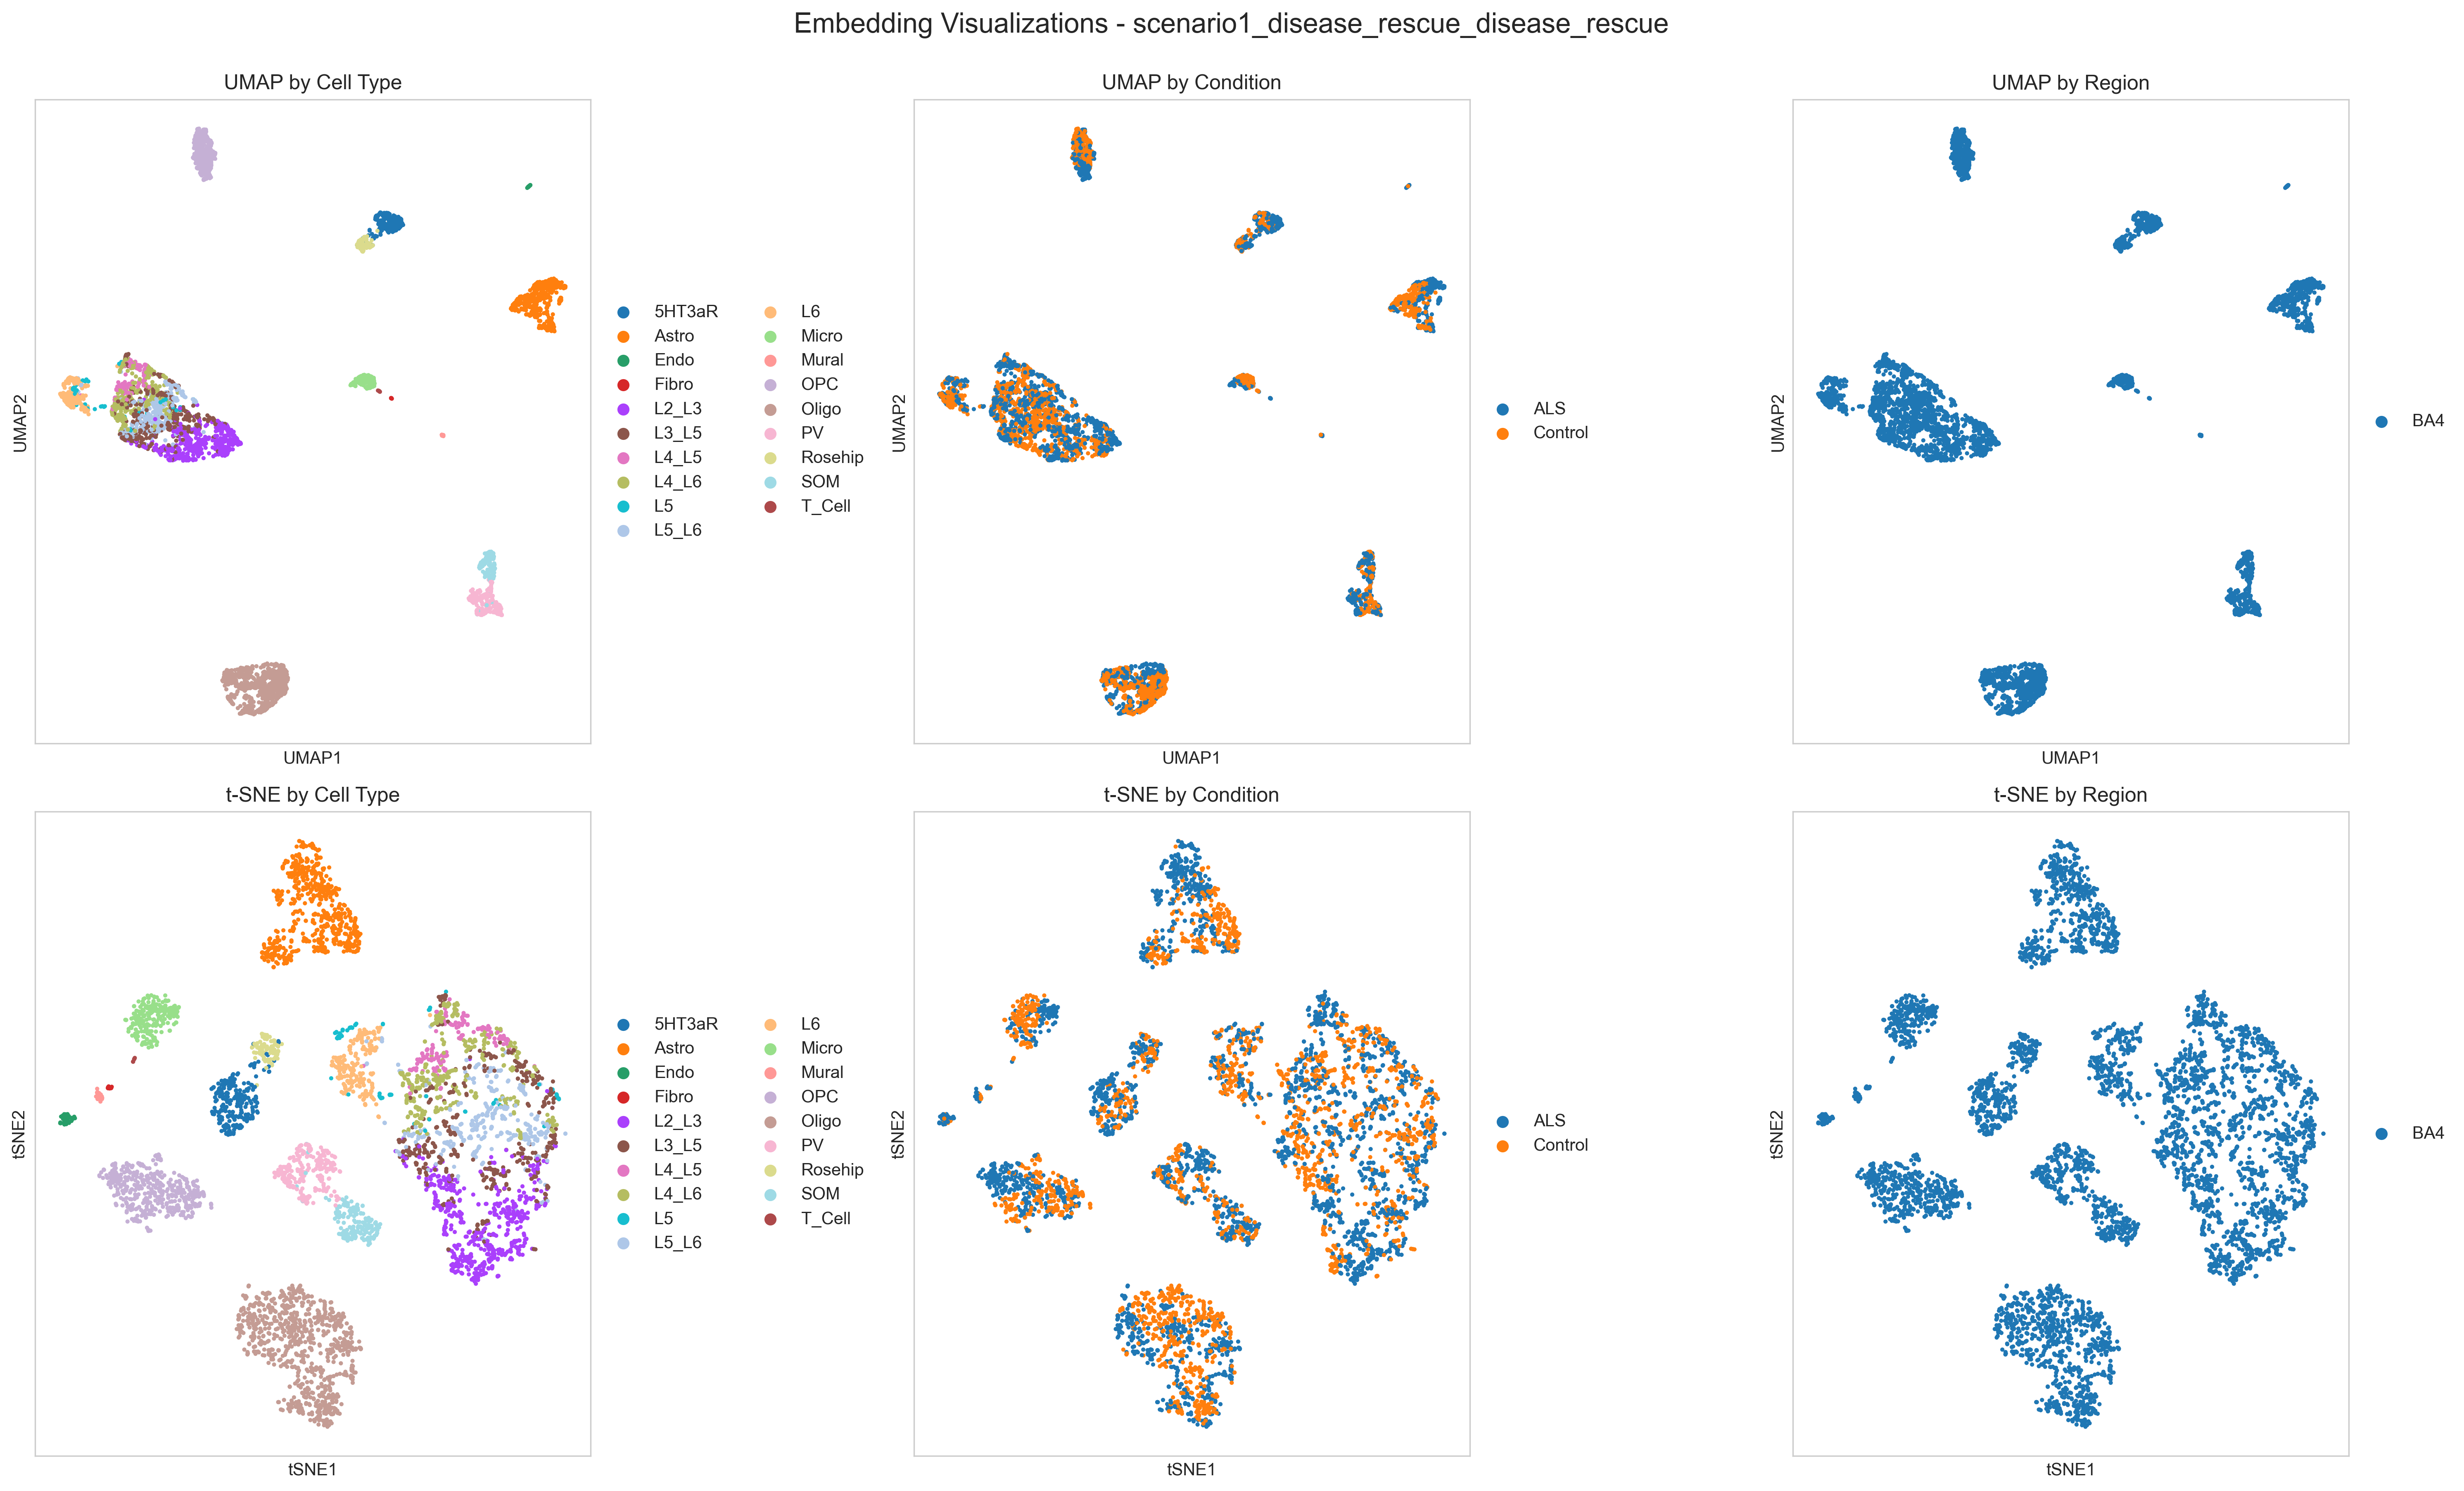

In [55]:
figure_labels = list(FIGURES.keys())
if figure_labels:
    first_label = figure_labels[0]
    display(Markdown(f"### Snapshot: {first_label}"))
    show_figure(first_label)
else:
    display(Markdown('No figures available.'))

if ENABLE_WIDGETS and figure_labels:
    figure_buttons = ToggleButtons(
        options=figure_labels,
        description='Figure:',
        button_style='',
        layout=Layout(width='100%')
    )
    figure_output = Output(layout=Layout(border='1px solid #1f2933', padding='12px'))

    def refresh_figure(change=None):
        with figure_output:
            figure_output.clear_output()
            show_figure(figure_buttons.value)

    figure_buttons.observe(refresh_figure, names='value')
    refresh_figure()
    display(VBox([figure_buttons, figure_output], layout=Layout(gap='12px')))
elif not ENABLE_WIDGETS:
    display(Markdown('_Widgets disabled (set ENABLE_WIDGETS=1 to enable interactive controls)._'))


## Differential Expression Explorer
Top genes rendered statically with optional widget controls


In [56]:
if deg_df.empty:
    display(Markdown('No DEG table loaded.'))
else:
    display(Markdown('### Top Differentially Expressed Genes by |logFC|'))
    view_degs('Upregulated in ALS', 10, 'abs_logfc', render=True)
    if ENABLE_WIDGETS:
        interact(
            interactive_view_degs,
            direction=['Upregulated in ALS', 'Downregulated in ALS'],
            top_n=IntSlider(value=10, min=5, max=50, step=5, description='Top N'),
            sort_by=['abs_logfc', 'scores']
        )
    else:
        display(Markdown('_Widgets disabled (set ENABLE_WIDGETS=1 to enable interactive controls)._'))


### Top Differentially Expressed Genes by |logFC|

Gene  logFC  Score  FDR_BH
0       MT1X 27.397  1.150   1.000
1       CA11 27.129  0.863   1.000
2   KAZN-AS1 27.025  0.978   1.000
3     SORBS2 26.988  0.920   1.000
4    RPL36AL 26.888  0.920   1.000
5       MT1M 26.725  0.748   1.000
6  MACROH2A2 26.517  0.805   1.000
7     SEZ6L2 26.516  0.690   1.000
8    IGF2BP2 26.499  0.575   1.000
9     ELAVL4 26.446  0.690   1.000

interactive(children=(Dropdown(description='direction', options=('Upregulated in ALS', 'Downregulated in ALS')…

## Next Steps
- Set `ENABLE_WIDGETS=1` and re-run before presenting with RISE
- Use `jupyter nbconvert --to slides --post serve interactive_presentation.ipynb` to build shareable HTML
- Publish static HTML in `docs/` for GitHub Pages if you need a hosted deck
